# Exploratory Data Analyses - Retention for Manual
Data Challenge solution

- First, we are going to read, visualise and organise all tables

In [1]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Load the data

dtype_mapping = {
    'customer_id': 'category',
    'subscription_id': 'category'
}

acq_orders_df = pd.read_csv('../data/acq_orders.csv', dtype=dtype_mapping)
activity_df = pd.read_csv('../data/activity.csv', parse_dates=['from_date', 'to_date'], dtype=dtype_mapping)
customers_df = pd.read_csv('../data/customers.csv', dtype={'customer_id': 'category'})

In [2]:
# Display the first few rows of each dataset
print("\nAcquisition Orders Head:")
print(acq_orders_df.head())
print("\nActivity Head:")
print(activity_df.head())
print("\nCustomers Head:")
print(customers_df.head())


Acquisition Orders Head:
  customer_id taxonomy_business_category_group
0     1026819                Weight Loss Group
1     1169512                Weight Loss Group
2     1204351                Weight Loss Group
3     1019780                Weight Loss Group
4     1166196                Weight Loss Group

Activity Head:
  customer_id subscription_id  from_date    to_date
0       31922           19621 2019-09-06 2019-10-07
1        3095           36471 2020-05-26 2020-06-19
2       74237           54966 2020-11-02 2021-03-02
3       29966           60229 2020-11-30 2021-03-02
4       64520           46879 2020-12-04 2021-03-02

Customers Head:
  customer_id customer_country
0      201441   United Kingdom
1      122538   United Kingdom
2       38482   United Kingdom
3        7792   United Kingdom
4      289880   United Kingdom


Three tables with just a few columns

In [3]:
# Check for missing data
print("\nMissing Data in Acquisition Orders:")
print(acq_orders_df.isnull().sum())

print("\nMissing Data in Activity:")
print(activity_df.isnull().sum())

print("\nMissing Data in Customers:")
print(customers_df.isnull().sum())

# No missing data


Missing Data in Acquisition Orders:
customer_id                         0
taxonomy_business_category_group    0
dtype: int64

Missing Data in Activity:
customer_id        0
subscription_id    0
from_date          0
to_date            0
dtype: int64

Missing Data in Customers:
customer_id         0
customer_country    0
dtype: int64


The code above shows that there are no null values in any table

## Acquisition table

2 analyses to do:
1. See if customer ID repeats (i.e., some customers might be in more than one business category)
2. See the total number of customer ids for each business category

In [4]:
# 1
acq_orders_df['customer_id'].is_unique

True

Each customer has one and only one business category - Simplification?

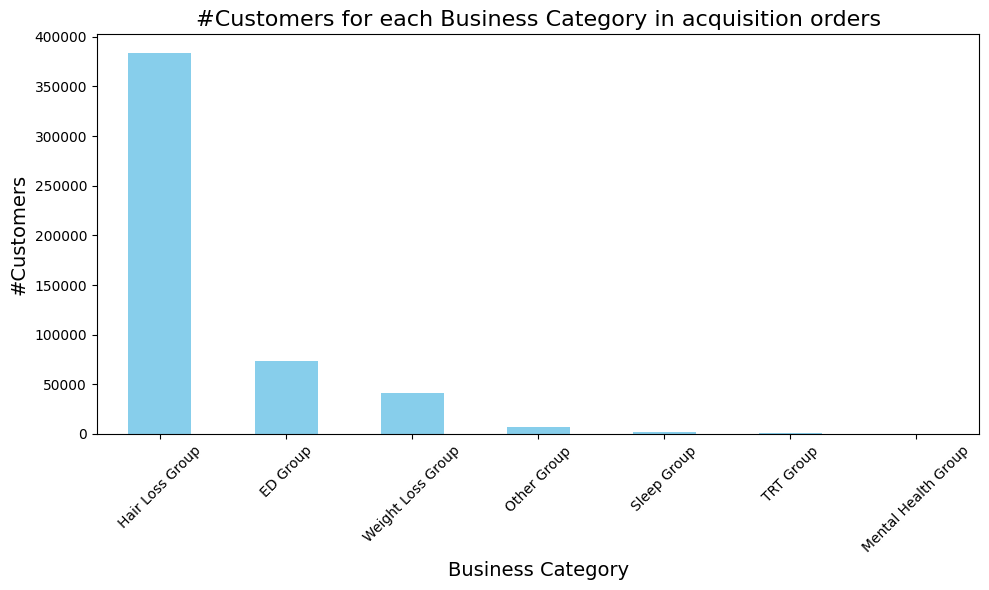

In [5]:
# 2

# Count the occurrences of each taxonomy_business_category_group
country_counts = acq_orders_df['taxonomy_business_category_group'].value_counts()

# Sort the counts in descending order
country_counts_sorted = country_counts.sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
country_counts_sorted.plot(kind='bar', color='skyblue')
plt.title('#Customers for each Business Category in acquisition orders', fontsize=16)
plt.xlabel('Business Category', fontsize=14)
plt.ylabel('#Customers', fontsize=14)
plt.xticks(rotation=45, fontsize=10) 
plt.tight_layout()
plt.show()

## Customers table

2 analyses to do:
1. See if customer ID repeats (i.e., some customers might be in more than one country)
2. See the count of customers for each country

In [6]:
# 1
customers_df['customer_id'].is_unique

True

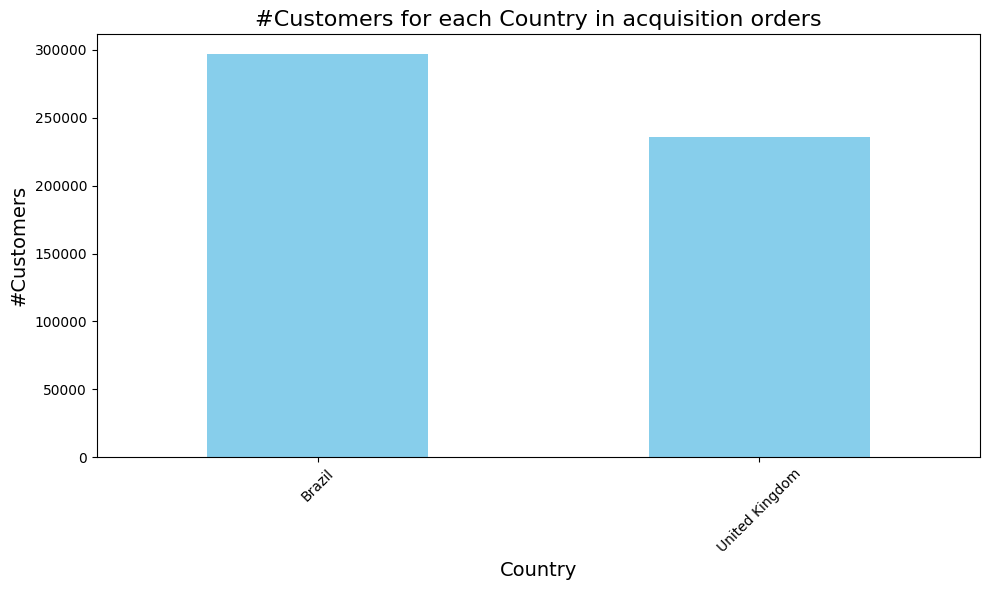

In [7]:
# 2

# Count the occurrences of each customer_country
country_counts = customers_df['customer_country'].value_counts()

# Sort the counts in descending order
country_counts_sorted = country_counts.sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
country_counts_sorted.plot(kind='bar', color='skyblue')
plt.title('#Customers for each Country in acquisition orders', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('#Customers', fontsize=14)
plt.xticks(rotation=45, fontsize=10) 
plt.tight_layout()
plt.show()

## Acitivity table

5 analyses to do:
1. Visualize min and max dates
2. Create a new column with duration of subscription (in days)
3. Check if there's flipped dates (duration < 0)
4. Check the distribution of subscriptions per customers and repeated subscriptions
5. See the distribution of duration

In [8]:
# 1

# Check date ranges
print("\nActivity Date Range:")
print(f"From Date Range: {activity_df['from_date'].min()} to {activity_df['from_date'].max()}")
print(f"To Date Range: {activity_df['to_date'].min()} to {activity_df['to_date'].max()}")



Activity Date Range:
From Date Range: 2019-01-04 00:00:00 to 2024-08-16 00:00:00
To Date Range: 2019-02-12 00:00:00 to 2024-08-16 00:00:00


The analysis above show that the max date is 2024-08-16. We'll consider this as the current date and these subscriptions will be censored in the survival analyses

No rows have subscription_duration less than 0.

Statistics about #subscriptons per customer
count    512366.000000
mean          2.892467
std           2.120012
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          65.000000
Name: subscription_id, dtype: float64


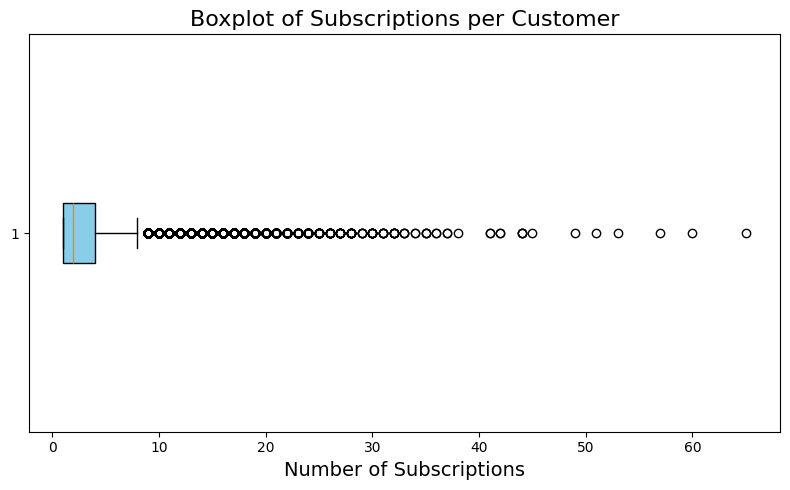

In [9]:
# 2
# Calculate the duration of the subscription in days
activity_df['subscription_duration'] = (activity_df['to_date'] - activity_df['from_date']).dt.days + 1

# 3
has_negative_durations = (activity_df['subscription_duration'] <= 0).any()

if has_negative_durations:
    print("There are rows where subscription_duration is less than 0.")
else:
    print("No rows have subscription_duration less than 0.")

# 4
# Group by 'customer_id' and count unique 'subscription_id'
subscription_per_customer = activity_df.groupby('customer_id', observed=True)['subscription_id'].nunique()

# Display the distribution
print('\nStatistics about #subscriptons per customer')
print(subscription_per_customer.describe())  # Summary statistics

# Plot boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(subscription_per_customer, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Boxplot of Subscriptions per Customer', fontsize=16)
plt.xlabel('Number of Subscriptions', fontsize=14)
plt.tight_layout()
plt.show()


In [10]:
# See repeated subscriptions
total_rows = len(activity_df)
# Count the unique combinations of customer_id + subscription_id
unique_combinations = activity_df[['customer_id', 'subscription_id']].drop_duplicates()
unique_rows = len(unique_combinations)

# Calculate the percentage of repeated combinations
repeated_percentage = ((total_rows - unique_rows) / total_rows) * 100

print(f"Percentage of repeated customer_id + subscription_id combinations: {repeated_percentage:.2f}%")

Percentage of repeated customer_id + subscription_id combinations: 31.90%


Outcomes from the analyses above:
- Date columns are well formatted
- Customers have more than one subscription on average (some have many subscriptions)
- From the acquisition table, customers only subscribe for one business category
- There's a high percentage of repeated customer_id + subscription_id in the table that has to be treated

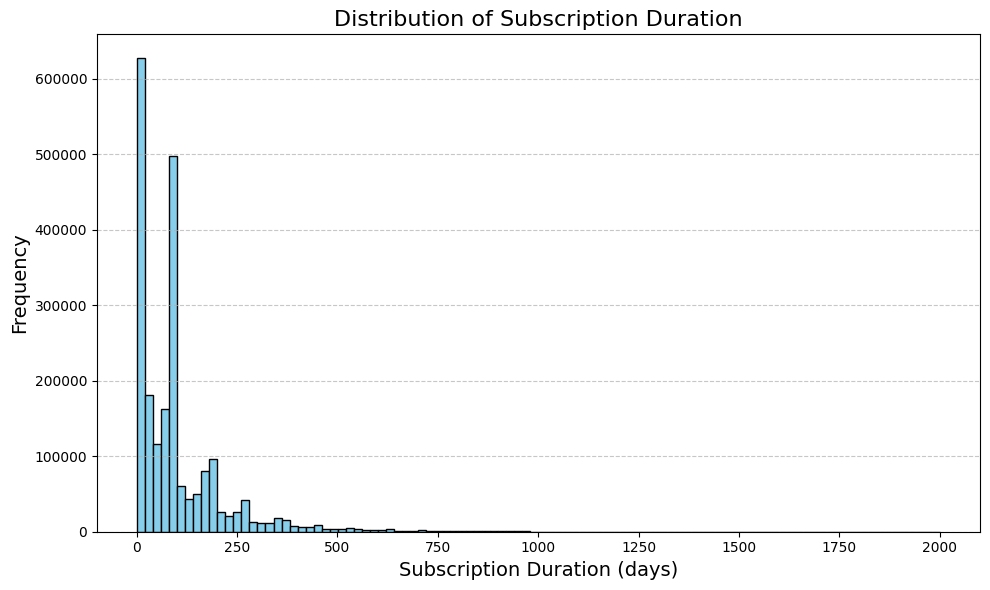

In [11]:
# 5

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(activity_df['subscription_duration'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Subscription Duration', fontsize=16)
plt.xlabel('Subscription Duration (days)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Interesting distribution of subscription durations!

In [12]:
# Extra - investigate one customer

# Find the customer
activity_df.groupby('customer_id', observed=True)['subscription_id'].nunique().sort_values(ascending=False).head()

customer_id
55798     65
41362     60
272999    57
99388     53
55413     51
Name: subscription_id, dtype: int64

Let's choose the first one

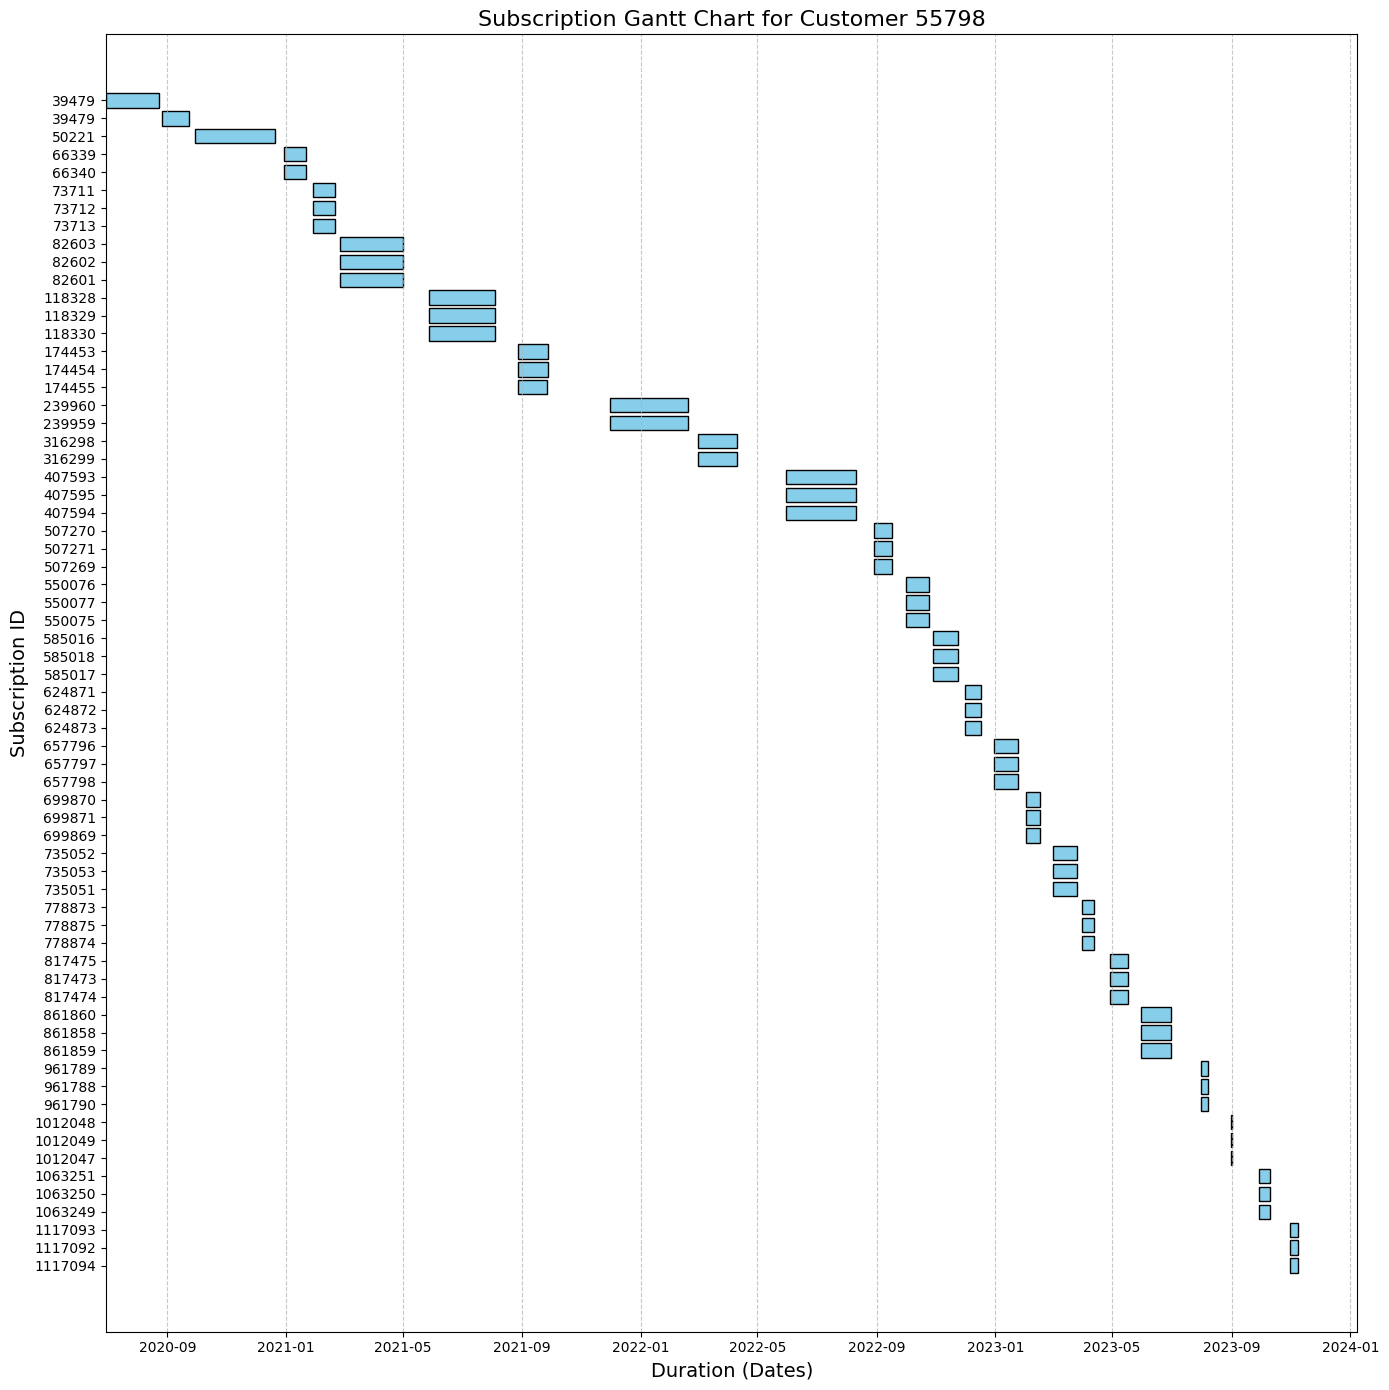

In [13]:
cid = '55798'

customer_data = activity_df[activity_df['customer_id'] == cid].copy()
customer_data = customer_data.sort_values(by='from_date', ascending=False)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 14))

# Plot each subscription as a horizontal bar
for i, row in enumerate(customer_data.itertuples()):
    ax.barh(
        y=i,  # Row index
        width=(row.to_date - row.from_date).days,  # Duration in days
        left=row.from_date,  # Start date
        color='skyblue', edgecolor='black'
    )

# Set y-ticks with subscription IDs
ax.set_yticks(range(len(customer_data)))
ax.set_yticklabels(customer_data['subscription_id'])

# Format the x-axis for dates
ax.xaxis_date()

# Set labels and title
ax.set_xlabel('Duration (Dates)', fontsize=14)
ax.set_ylabel('Subscription ID', fontsize=14)
ax.set_title(f'Subscription Gantt Chart for Customer {cid}', fontsize=16)

# Add grid for better readability
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


- The specific customer above shows us that one customer can have many subscriptions (maybe a big family or a company?). 
- Is this customer trying to get discounts by unsubscribing and subscribing again to the products?
- For the retention analysis, we can assume different things whether this customer churned or not between subscriptions. However, he has to be flagged as a "discount-driven customer"
- Let's define a threshold for "real churners", i.e., a customer that unsubscribed and came back after a long time. Given that Manual can send up to 3-month supply (to be confirmed with business), 3 months seem to be a realistic threshold. So, subscriptions that weren't followed by a new one after 93 days will be flagged as "churn".

In [16]:
activity_df[(activity_df['customer_id'] == '1134406')].sort_values(by=['subscription_id', 'from_date'])

,customer_id,subscription_id,from_date,to_date,subscription_duration
578069,1134406,1618620,2024-08-01,2024-08-02,2
1417754,1134406,1618620,2024-08-01,2024-08-01,1
1646749,1134406,1618620,2024-08-02,2024-08-02,1
1977884,1134406,1618620,2024-08-02,2024-08-03,2
735289,1134406,1618620,2024-08-03,2024-08-03,1
...,...,...,...,...,...
734633,1134406,1618623,2024-08-01,2024-08-02,2
578396,1134406,1618623,2024-08-02,2024-08-02,1
917632,1134406,1624231,2024-08-01,2024-08-01,1
1456756,1134406,1624231,2024-08-01,2024-08-02,2


- One more interesting example above
- Sometimes, one customer has the same subscription with multiple 'from_date' and 'to_date' values.
- What does this behaviour mean? Ask someone from the business
- These cases have to be unified.

## Cleaning steps
1. Unify duplicates of customer_id and subscription_id > This is a simplification of the problem. Further investigation required to understand how this data was generated
2. Get a consistent table of subscription duration

In [35]:
# 1

# Group by customer_id and subscription_id
unified_activity_df = (
    activity_df.groupby(['customer_id', 'subscription_id'], observed=True, as_index=False)
    .agg({
        'from_date': 'min',
        'to_date': 'max',
    })
)

# Recalculate the subscription duration
unified_activity_df['subscription_duration'] = (unified_activity_df['to_date'] - unified_activity_df['from_date']).dt.days + 1

print(unified_activity_df)

        customer_id subscription_id  from_date    to_date  subscription_duration
0                 1               1 2019-01-04 2019-02-12                     40
1                 1           13350 2019-06-17 2019-06-17                      1
2                 1           29418 2020-02-19 2020-03-20                     31
3                 1           28109 2020-01-29 2020-01-29                      1
4                 1           13524 2019-08-20 2019-08-22                      3
...             ...             ...        ...        ...                    ...
1481997       99846           71797 2021-01-25 2021-05-18                    114
1481998       99907           71834 2021-01-25 2021-03-07                     42
1481999      999085         1398255 2024-03-15 2024-06-13                     91
1482000      999398         1398811 2024-03-16 2024-07-31                    138
1482001      999987         1399637 2024-03-17 2024-05-13                     58

[1482002 rows x 5 columns]


In [36]:
# 2
# Sort data by customer and subscription start date
unified_activity_df = unified_activity_df.sort_values(by=['customer_id', 'from_date'])

# Calculate the gap between subscriptions
unified_activity_df['gap'] = unified_activity_df.groupby('customer_id', observed=True)['from_date'].shift(-1) - unified_activity_df['to_date']

# Define churn threshold (93 days - 3 months)
churn_threshold = pd.Timedelta(days=93)

max_to_date = unified_activity_df['to_date'].max()

# Flag churn events
unified_activity_df['is_churn'] = (
    (unified_activity_df['gap'] > churn_threshold) | 
    ((unified_activity_df['to_date'] < max_to_date) & (pd.isnull(unified_activity_df['gap'])))
)

Look at the example below. Subscription IDs 10016, 13350 and 13524 should be merged as one, following our rationale of "discount-driven customers". Same for subscriptions 28109, 28108, 29418 and 29417

In [37]:
unified_activity_df[unified_activity_df.customer_id == '1']

,customer_id,subscription_id,from_date,to_date,subscription_duration,gap,is_churn
0,1,1,2019-01-04,2019-02-12,40,108 days,True
6,1,10016,2019-05-31,2019-05-31,1,17 days,False
1,1,13350,2019-06-17,2019-06-17,1,64 days,False
4,1,13524,2019-08-20,2019-08-22,3,160 days,True
3,1,28109,2020-01-29,2020-01-29,1,0 days,False
7,1,28108,2020-01-29,2020-01-29,1,21 days,False
2,1,29418,2020-02-19,2020-03-20,31,-30 days,False
5,1,29417,2020-02-19,2020-03-20,31,NaT,True


Executing the merge proposed above and tagging censored subscriptions..

In [38]:
# Tag censored subscriptions
unified_activity_df['censored'] = unified_activity_df['to_date'] == max_to_date

# Step 3: Assign group numbers for combining non-churned rows
unified_activity_df['new_group'] = (
    (unified_activity_df['customer_id'] != unified_activity_df['customer_id'].shift())  # First row per customer
    | (unified_activity_df['is_churn'].shift(fill_value=False))  # After a churn
    | (unified_activity_df['censored'])  # Censored row starts a new group
)

# Assign group IDs using cumsum
unified_activity_df['combine_group'] = unified_activity_df['new_group'].cumsum()


In [40]:
# Step 4: Group and aggregate
combined_df = (
    unified_activity_df
    .groupby(['customer_id', 'combine_group'], observed=True, as_index=False)
    .agg({
        'subscription_id': 'first',           # Take the first subscription_id in the group
        'from_date': 'min',                  # Earliest from_date in the group
        'to_date': 'max',                    # Latest to_date in the group
        'censored': 'max'                    # If any row is censored, set censored to True
    })
)

# Step 5: Filter groups that end with churn or are censored
churn_groups = unified_activity_df.loc[unified_activity_df['is_churn'], 'combine_group'].unique()
final_activity_df = combined_df[
    combined_df['censored'] | combined_df['combine_group'].isin(churn_groups)
]

# Drop unnecessary columns
final_activity_df = final_activity_df[['customer_id', 'subscription_id', 'from_date', 'to_date', 'censored']]

# Recalculate subscription_duration
final_activity_df['subscription_duration'] = (final_activity_df['to_date'] - final_activity_df['from_date']).dt.days + 1

print(final_activity_df)

       customer_id subscription_id  from_date    to_date  censored  subscription_duration
0                1               1 2019-01-04 2019-02-12     False                     40
1                1           10016 2019-05-31 2019-08-22     False                     84
2                1           28109 2020-01-29 2020-03-20     False                     52
3           100001           74217 2021-01-30 2021-04-23     False                     84
5          1000014         1633947 2024-06-28 2024-08-16      True                     50
...            ...             ...        ...        ...       ...                    ...
603474       99846           71797 2021-01-25 2021-05-18     False                    114
603475       99907           71834 2021-01-25 2021-03-07     False                     42
603476      999085         1398255 2024-03-15 2024-06-13     False                     91
603477      999398         1398811 2024-03-16 2024-07-31     False                    138
603478    

Checking the expected outcome for the example

In [43]:
print(final_activity_df[final_activity_df['customer_id'] == '1'])

  customer_id subscription_id  from_date    to_date  censored  subscription_duration
0           1               1 2019-01-04 2019-02-12     False                     40
1           1           10016 2019-05-31 2019-08-22     False                     84
2           1           28109 2020-01-29 2020-03-20     False                     52


Looks good!

Let's now merge the final activity table with the other tables

In [44]:
# Merge the datasets based on customer_id
final_df = pd.merge(final_activity_df, customers_df, on='customer_id', how='left')
final_df = pd.merge(final_df, acq_orders_df, on='customer_id', how='left')

# Display merged dataset
print("\nMerged Dataset Head:")
print(final_df.head())


Merged Dataset Head:
  customer_id subscription_id  from_date    to_date  censored  subscription_duration customer_country taxonomy_business_category_group
0           1               1 2019-01-04 2019-02-12     False                     40   United Kingdom                  Hair Loss Group
1           1           10016 2019-05-31 2019-08-22     False                     84   United Kingdom                  Hair Loss Group
2           1           28109 2020-01-29 2020-03-20     False                     52   United Kingdom                  Hair Loss Group
3      100001           74217 2021-01-30 2021-04-23     False                     84   United Kingdom                  Hair Loss Group
4     1000014         1633947 2024-06-28 2024-08-16      True                     50   United Kingdom                Weight Loss Group


In [56]:
# Export result
final_df.to_feather('../data_results/final_df.ftr')